In [29]:
import importlib
import di_rnn
importlib.reload(di_rnn)

<module 'di_rnn' from 'c:\\Users\\janav\\Documents\\load forecasting\\local-stlf\\di-rnn\\di_rnn.py'>

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from di_rnn import DIRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [44]:
def preprocess_data(csv_path, m=4, n=3, freq='30min', splits=(0.6, 0.1, 0.3), horizon=1):
    print("📥 Loading and preprocessing data...")

    # === Load and resample ===
    df = pd.read_csv(csv_path, sep=';', decimal=',')
    df['ts'] = pd.to_datetime(df['ts'])
    df.set_index('ts', inplace=True)
    df = df.sort_index().resample(freq).mean()
    df['vrednost'] = df['vrednost'].interpolate()

    # === Split into train, val, test ===
    total_len = len(df)
    train_end = int(total_len * splits[0])
    val_end = train_end + int(total_len * splits[1])

    df_train = df.iloc[:train_end].copy()
    df_val   = df.iloc[train_end:val_end].copy()
    df_test  = df.iloc[val_end:].copy()

    # === Normalize ===
    print("🔢 Scaling values...")
    scaler = MinMaxScaler()
    df_train['scaled'] = scaler.fit_transform(df_train[['vrednost']])
    df_val['scaled']   = scaler.transform(df_val[['vrednost']])
    df_test['scaled']  = scaler.transform(df_test[['vrednost']])

    df_all = pd.concat([df_train, df_val, df_test])
    values = df_all['scaled']
    timestamps = values.index

    # === Prepare sequences ===
    print("🧩 Constructing input sequences...")
    min_required = max(m, n * int(pd.Timedelta('1D') / pd.to_timedelta(freq)))
    X_seq, X_per, y = [], [], []

    for idx in range(min_required, len(timestamps) - horizon):
        t = timestamps[idx]

        # Short-term input (S-RNN)
        s_start = t - m * pd.to_timedelta(freq)
        s_range = pd.date_range(start=s_start, periods=m, freq=freq)
        if not all(ts in df_all.index for ts in s_range):
            continue
        s_input = df_all.loc[s_range, 'scaled'].values.reshape(m, 1)

        # Periodic input (P-RNN)
        p_input = []
        for i in range(1, n + 1):
            prev_day_time = t - pd.Timedelta(days=i)
            if prev_day_time in df_all.index:
                p_input.append(df_all.loc[prev_day_time, 'scaled'])
            else:
                break
        if len(p_input) != n:
            continue
        p_input = np.array(p_input).reshape(n, 1)

        # Horizon target
        y_start = s_range[-1] + pd.to_timedelta(freq)
        y_range = pd.date_range(start=y_start, periods=horizon, freq=freq)
        if not all(ts in df_all.index for ts in y_range):
            continue
        y_output = df_all.loc[y_range, 'scaled'].values

        X_seq.append(s_input)
        X_per.append(p_input)
        y.append(y_output)

    # === Convert to arrays ===
    X_seq = np.array(X_seq)
    X_per = np.array(X_per)
    y = np.array(y)

    # === Final splits ===
    total_samples = len(y)
    train_end = int(total_samples * splits[0])
    val_end = train_end + int(total_samples * splits[1])

    print(f"✅ Dataset sizes → Train: {train_end}, Val: {val_end - train_end}, Test: {total_samples - val_end}")

    data = {
        'train': (X_seq[:train_end], X_per[:train_end], y[:train_end]),
        'val':   (X_seq[train_end:val_end], X_per[train_end:val_end], y[train_end:val_end]),
        'test':  (X_seq[val_end:], X_per[val_end:], y[val_end:])
    }

    return data, scaler


In [17]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        se = (y_true - y_pred) ** 2
        return torch.sqrt(torch.mean(se) + self.eps)


In [56]:
def train_dirnn(model, train_data, val_data, epochs=20, lr_rnn=0.005, lr_bpnn=0.008, device='cpu', patience=5):
    print("🚂 Starting training...")
    model = model.to(device)
    optimizer = torch.optim.Adam([
        {'params': model.s_rnn.parameters(), 'lr': lr_rnn},
        {'params': model.p_rnn.parameters(), 'lr': lr_rnn},
        {'params': model.bpnn.parameters(), 'lr': lr_bpnn},
    ])

    criterion = RMSELoss()

    X_seq_train, X_per_train, y_train = [torch.tensor(x, dtype=torch.float32).to(device) for x in train_data]
    X_seq_val, X_per_val, y_val = [torch.tensor(x, dtype=torch.float32).to(device) for x in val_data]

    print("Train target shape:", y_train.shape)
    print("Train pred shape:  ", model(X_seq_train, X_per_train).shape)

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_seq_train, X_per_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_seq_val, X_per_val)
            val_loss = criterion(val_pred, y_val)

        print(f"\r📘 Epoch {epoch+1:02d}/{epochs} — \U0001F4CA Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}")

        # Early stopping check
        if val_loss.item() < best_val_loss - 1e-5:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping triggered at epoch {epoch+1}. Best Val Loss: {best_val_loss:.6f}")
                break

    # Restore best model state
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model


In [45]:
print("🚀 Running DI-RNN pipeline...")
horizon = 4
data, scaler = preprocess_data('mm79158.csv', m=192, n=7, horizon=4, freq='30min')
train_data = data['train']
val_data = data['val']
test_data = data['test']

🚀 Running DI-RNN pipeline...
📥 Loading and preprocessing data...
🔢 Scaling values...
🧩 Constructing input sequences...
✅ Dataset sizes → Train: 36112, Val: 6018, Test: 18058


In [57]:
print("🧠 Initializing DIRNN model...")
model = DIRNN(seq_input_size=1, per_input_size=1, hidden_size=64, bp_hidden_size=128, dropout=0.2, horizon=horizon)

train_dirnn(model, train_data, val_data, epochs=20, lr_rnn=0.005, lr_bpnn=0.008, device='cpu')

🧠 Initializing DIRNN model...
🚂 Starting training...
Train target shape: torch.Size([36112, 4])
Train pred shape:   torch.Size([36112, 4])
📘 Epoch 01/20 — 📊 Train Loss: 0.091164 | Val Loss: 0.223881
📘 Epoch 02/20 — 📊 Train Loss: 0.201597 | Val Loss: 0.140232
📘 Epoch 03/20 — 📊 Train Loss: 0.120280 | Val Loss: 0.088501
📘 Epoch 04/20 — 📊 Train Loss: 0.092386 | Val Loss: 0.112331
📘 Epoch 05/20 — 📊 Train Loss: 0.125751 | Val Loss: 0.102819
📘 Epoch 06/20 — 📊 Train Loss: 0.114087 | Val Loss: 0.086984
📘 Epoch 07/20 — 📊 Train Loss: 0.084884 | Val Loss: 0.121530
📘 Epoch 08/20 — 📊 Train Loss: 0.103568 | Val Loss: 0.120583
📘 Epoch 09/20 — 📊 Train Loss: 0.102667 | Val Loss: 0.101656
📘 Epoch 10/20 — 📊 Train Loss: 0.088253 | Val Loss: 0.087853
📘 Epoch 11/20 — 📊 Train Loss: 0.083525 | Val Loss: 0.087419
⏹️ Early stopping triggered at epoch 11. Best Val Loss: 0.086984


DIRNN(
  (s_rnn): FCRNN(
    (rnn1): RNN(1, 64, batch_first=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (rnn2): RNN(64, 64, batch_first=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=4, bias=True)
  )
  (p_rnn): FCRNN(
    (rnn1): RNN(1, 64, batch_first=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (rnn2): RNN(64, 64, batch_first=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=4, bias=True)
  )
  (bpnn): BPNN(
    (fc1): Linear(in_features=2, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [58]:
model.eval()
device = 'cpu'

X_seq_test, X_per_test, y_test = test_data
X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32).to(device)
X_per_test = torch.tensor(X_per_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

preds = []

with torch.no_grad():
    for i in range(0, len(X_seq_test)):
        seq_x = X_seq_test[i].unsqueeze(0)  # [1, m, 1]
        per_x = X_per_test[i].unsqueeze(0)  # [1, n, 1]

        pred = model(seq_x, per_x).squeeze(0).cpu().numpy()  # [horizon]
        preds.append(pred)

preds = np.array(preds)  # [samples, horizon]
true_vals = y_test.cpu().numpy()  # [samples, horizon]

# Rescale to original units
preds_rescaled = scaler.inverse_transform(preds)
true_rescaled = scaler.inverse_transform(true_vals)


In [59]:
preds_rescaled.shape, true_rescaled.shape

((18058, 4), (18058, 4))

In [62]:
preds_rescaled.max(), preds_rescaled.min()

(np.float32(3.0749555), np.float32(2.7928925))

In [60]:
mae = mean_absolute_error(true_rescaled, preds_rescaled)
mse = mean_squared_error(true_rescaled, preds_rescaled)
mape = mean_absolute_percentage_error(true_rescaled, preds_rescaled)

print("\n📊 Evaluation Metrics:")
print(f"✅ MAE:  {mae:.4f}")
print(f"✅ MSE:  {mse:.4f}")
print(f"✅ MAPE: {mape:.4f}")


📊 Evaluation Metrics:
✅ MAE:  1.8758
✅ MSE:  4.6678
✅ MAPE: 2.2048


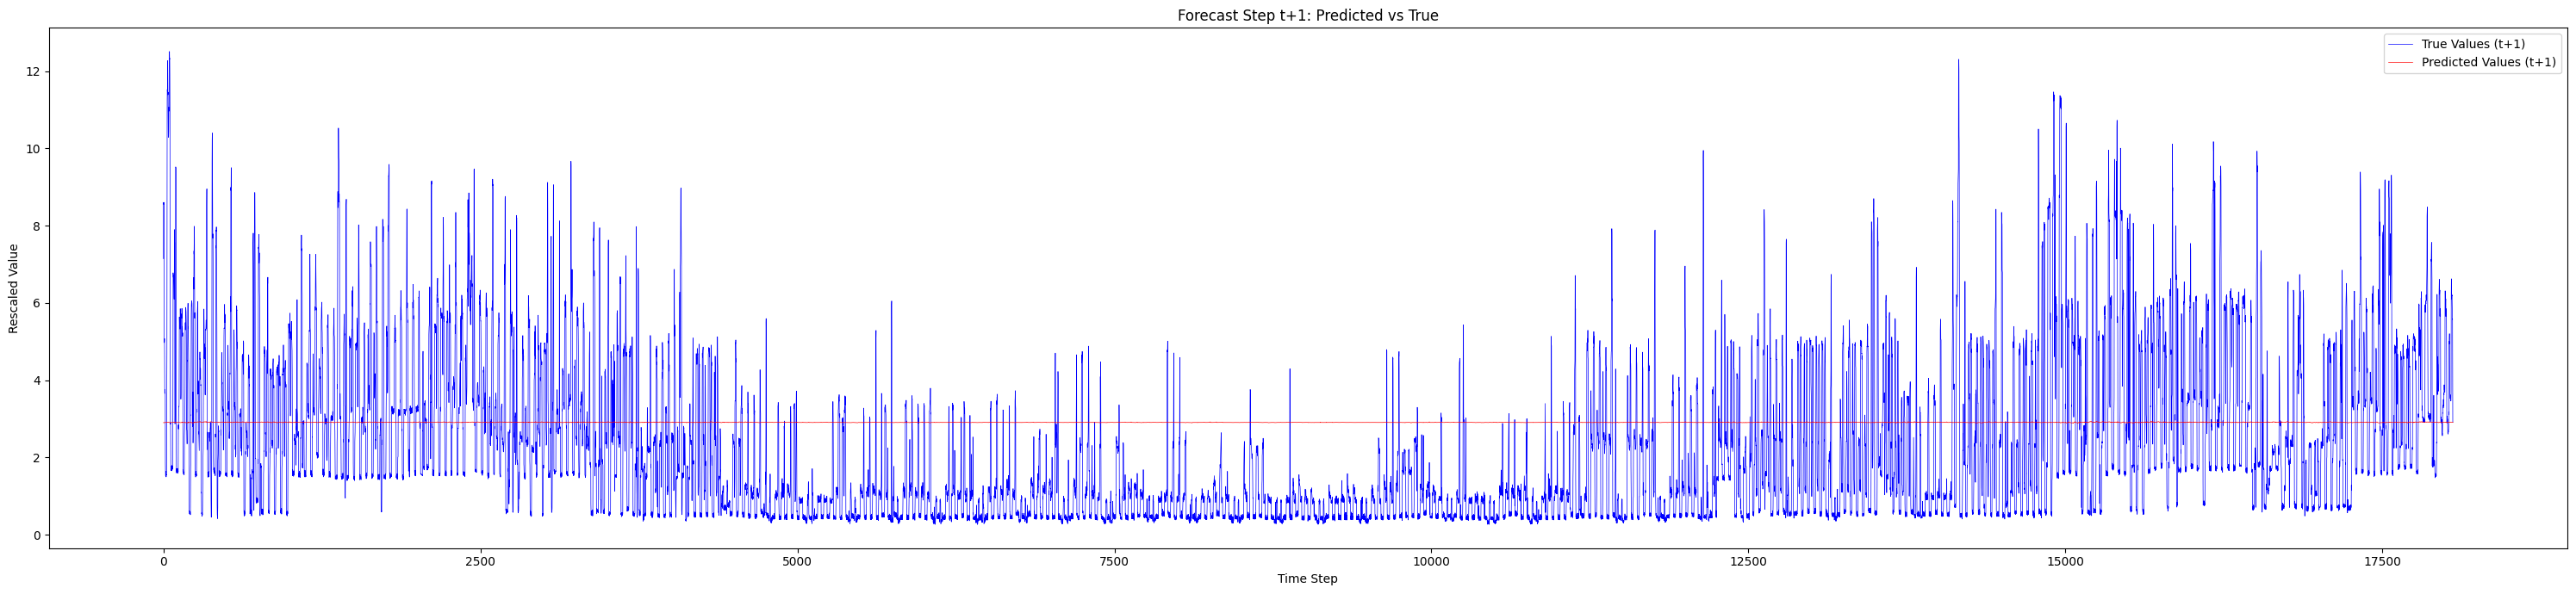

In [61]:
# Only take the first step from each prediction horizon
pred_step1 = preds_rescaled[:, 0]
true_step1 = true_rescaled[:, 0]

# Now plot 1:1 aligned forecast
plt.figure(figsize=(30, 7))
plt.plot(true_step1, color='blue', linewidth=0.5, label='True Values (t+1)')
plt.plot(pred_step1, color='red', linewidth=0.5, label='Predicted Values (t+1)')
plt.title("Forecast Step t+1: Predicted vs True")
plt.xlabel("Time Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()
